# Bayesian Logistic Regression

Contact: mihaelacr@google.com

Aim of this colab:
Logistic regression with a twist! We will use variational inference to learn a distribution over the learned parameters.

Througout this work we will be focusing on a binary classification task, on 
a small dataset (the UCD breast cancer dataset). 


## Logistic regression

Learn the weights which best classify the $(x, y)$ pairs in the dataset. 
The weights ($w$) and biases $b$, form the parameters which are learned via the following maximization problem:

\begin{equation}
\mathbb{E}_{p^*(x, y)} \log p(y|x, \theta) = \\
 \mathbb{E}_{p^*(x, y)} \left[y \log \sigma(w x + b) + (1 - y) \log(1- \sigma(w x + b)\right] 
\end{equation}

Here $\sigma$ denotes the sigmoid function.

## Bayesian logistic regression - computing the evidence lower bound

Learn a distribution over the weights which best classify the $(x, y)$ pairs in the dataset.

We now want to learn the distributional parameters of $q(w)$ in order to maximize:

\begin{equation}
\mathbb{E}_{p^*(x, y)} \log p_w(y| x) = \\
\mathbb{E}_{p^*(x, y)} \log \int p(y|x, w) p(w) \delta w = \\
\mathbb{E}_{p^*(x, y)} \log \int p(y|x, w) p(w) \frac{q(w)}{q(w)} \delta w \ge \\
\mathbb{E}_{p^*(x, y)} \mathbb{E}_{q(w)} \log \left[p(y| x, w) \frac{p(w)}{q(w)} \right]= \\
\mathbb{E}_{q(w)} \mathbb{E}_{p^*(x, y)} \log p(y|x, w)  -  KL(q(w)||p(w)) = \\
 \mathbb{E}_{q(w)}\mathbb{E}_{p^*(x, y)} \left[y \log \sigma(w x + b) + (1 - y) \log(1- \sigma(w x + b)\right] -  KL(q(w)||p(w))
\end{equation}

In Bayesian Logistic Regression, we thus learn a distribution over parameters
$w$ which can explain the data, while staying close to a chosen prior $p(w)$.

Throughout this lab, we will use Gaussian Distributions for $p(w)$ and $q(w)$.

For more details, see 
[this paper](https://pdfs.semanticscholar.org/e407/ea7fda6d152d2186f4b5e27aa04ec2d32dcd.pdf) 
or this tutorial
[https://www.ece.rice.edu/~vc3/elec633/logistic.pdf].

### Gradient estimation

In Bayesian Logistic Regression, we aim to learn the parameters of the distribution $q(w)$. We will call these parameters $\theta$. In the case of a 
Gaussian distribution, these will be the mean and covariance matrix of a
multivariate distribution. Since we will use stochastic gradient descent to learn $\theta$, we need to be able to compute the gradients with respect to 
$\theta$ of our objective. Since our objective contains an expectation with respect to $q(w)$, this can be challenging. To illustrate this, from now on we will denote $q(w)$ as $q_{\theta}(w)$.

Specifically, we are interested in:
\begin{equation}
  \nabla_{\theta} \left[\mathbb{E}_{q_{\theta}(w)} \mathbb{E}_{p^*(x, y)} \log p(y|x, w)  -  KL(q_{\theta}(w)||p(w))\right]
\end{equation}

Since in we will be using Gaussian distributions for $q_{\theta}(w)$ and $p(w)$ 
$KL(q_{\theta}(w)||p(w))$ can be computed in closed form and we can rely on 
TensorFlow's automatic differentiation to compute 
$\nabla_{\theta} KL(q_{\theta}(w)||p(w))$.

Let's now turn attention to computing $\nabla_{\theta} \mathbb{E}_{q_{\theta}(w)} \mathbb{E}_{p^*(x, y)} \log p(y| x, w)$. Unlike the KL, the integral 
$\mathbb{E}_{q_{\theta}(w)} \mathbb{E}_{p^*(x, y)} \log p(y|x, w)$
is not tractable, and thus cannot be computed in closed form. Thus, we are interested in other approaches to compute the gradient.

### Reinforce gradient estimation

A first approach to compute an estimate of the gradient is to use the
REINFORCE gradient estimator:

\begin{equation}
  \nabla_{\theta} \mathbb{E}_{q_{\theta}(w)} \mathbb{E}_{p^*(x, y)} \log p(y| x, w)  = \\
  \nabla_{\theta} \int q_{\theta}(w) \mathbb{E}_{p^*(x, y)} \log p(y| x, w) \delta w = \\
  \int \nabla_{\theta} \left[q_{\theta}(w) \mathbb{E}_{p^*(x, y)} \log p(y| x, w) \right] \delta w = \\
 \int \nabla_{\theta} \left[q_{\theta}(w)\right] \mathbb{E}_{p^*(x, y)} \log p(y| x, w) \delta w = \\
 \int q_{\theta}(w) \nabla_{\theta} \left[\log q_{\theta}(w)\right] \mathbb{E}_{p^*(x, y)} \log p(y| x, w)  \delta w = \\
 \mathbb{E}_{q_{\theta}(w)} \left[ \nabla_{\theta} \log q_{\theta}(w) \mathbb{E}_{p^*(x, y)} \log p(y| x, w) \right]
\end{equation}

We can use samples from $q_{\theta}(w)$ to compute the Monte Carlo estimate of
the last integral, to get an unbiased estimator of the true gradient. The more 
samples we use to estimate the integral, the more accurate the gradient estimate
will be.


### Pathwise gradient estimation (reparametrization)

In the REINFORCE estimator, we did not use any knowledge of the variational
distribution $q_{\theta}(w)$.
For a Gaussian distribution, we can use the reparametrization trick to obtain
an unbiased gradient estimator of  $\nabla_{\theta} \mathbb{E}_{q_{\theta}(w)} \mathbb{E}_{p^*(x, y)} \log p(y| x, w)$.

To do so, we will use the fact that 
\begin{equation}
    z \sim N(\mu, \sigma), z = \mu + \epsilon \sigma, {\text {with }} \epsilon \sim N(0, 1)
\end{equation}

Namely:
\begin{equation}
  \nabla_{\theta} \mathbb{E}_{q_{\theta}(w)} \mathbb{E}_{p^*(x, y)} \log p(y| x, w)  = \\
  \nabla_{\theta} \mathbb{E}_{p(\epsilon)} \mathbb{E}_{p^*(x, y)} \log p(y| x, \mu + \epsilon \sigma)  = \\
  \mathbb{E}_{p(\epsilon)} \nabla_{\theta} \mathbb{E}_{p^*(x, y)} \log p(y| x, \mu + \epsilon \sigma)
\end{equation}

Note that we were able to move the gradient inside the integral since 
$p(\epsilon)$ does not depend on $\theta$.
To estimate the last integral, we can use a Monte Carlo estimate using samples
of $p(\epsilon)$.


## Your tasks


*   Define the Gaussian posterior distribution.
*   Fill in the code for the ELBO
*   Fill in the reinforce function to create the surrogate loss
*   Fill in the loss function for reparametrization
*   Visualize the effects of batch size, learning rates and number of posterior samples on the learned model, as well as gradient variance.



In [0]:
import enum
import numpy as np

import math
from sklearn import datasets
from sklearn import linear_model
import collections

from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns

tfd = tfp.distributions

#ELBO je evidence lower bound.


In [0]:
sns.set(rc={"lines.linewidth": 2.8}, font_scale=2)
sns.set_style("whitegrid")

## Get the dataset and visualize it

In [0]:
def get_data(normalize = True):
    data = datasets.load_breast_cancer()

    print(data.target_names)
    print(data.feature_names)

    features = np.array(data.data, dtype=np.float32)
    targets = np.array(data.target, dtype=np.float32)

    if normalize:
        # Note: the data dimensions have very different scales.
        # We normalize by the mean and scale of the entire dataset.
        features = features - features.mean(axis=0)
        features = features / features.std(axis=0)

    # Add a dimension of 1 (bias).
    features = np.concatenate((features, np.ones((features.shape[0], 1))), axis=1)
    features = np.array(features, dtype=np.float32)
  
    return features, targets, data.feature_names

### Dataset

This datasets has meaningful features: we are trying to classify based on these features whether someone has breast cancer or not. We can look at the
features we are using to classify the data below.


In [4]:
features, targets, feature_names = get_data()

['malignant' 'benign']
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


### Trivial baseline

How well can we do with a constant classifier?

If we look at the average label, we can see how many 1s are in the data, so we know that our classifier has to get more than that accuracy

In [5]:
np.mean(targets)

0.6274165

In [6]:
features.shape

(569, 31)

In [0]:
dataset_size = features.shape[0]
data_dims = features.shape[-1]

## Logistic regression baseline - how well can we do on this dataset?

Let's look at a simple, non Bayesian classification approach to get an idea of how well we can do on the dataset. 

In [0]:
lr = linear_model.LogisticRegression()

In [9]:
lr.fit(features, targets)
lr.score(features, targets)

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9876977152899824

## Utilities

In [0]:
def get_shape_list(tensor):
  return tensor.shape.as_list()

In [0]:
def get_sklearn_data_as_tensors(
      features, targets, batch_size, dataset_name='breast_cancer'):
  """Read sklearn datasets as tf.Tensors.

  Args:
    batch_size: Integer or None. If None, the entire dataset is used.
    dataset_name: A string, the name of the dataset.

  Returns:
    A tuple of size two containing two tensors of rank 2 `[B, F]`, the data
    features and targets.
  """
  dataset = tf.data.Dataset.from_tensor_slices((features, targets))
  if batch_size:
    # Shuffle, repeat, and batch the examples.
    batched_dataset = dataset.shuffle(1000).repeat().batch(batch_size)
  else:
    batch_size = features.shape[0]
    batched_dataset = dataset.repeat().batch(batch_size)

  iterator = batched_dataset.make_one_shot_iterator()
  batch_features, batch_targets = iterator.get_next()

  data_dim = features.shape[1]
  batch_features.set_shape([batch_size, data_dim])
  batch_targets.set_shape([batch_size])

  return batch_features, batch_targets

## Bayesian Logistic Regression - define the prior and the posterior

We will learn a distribution over parameters, so we will first define prior distribution, and then a posterior distribution over parameters which we 
will learn.

Both of these distibutions will be Gaussian.

## Task: implement the posterior distribution

You have to implement two functions 


1.   multi_normal, which takes as arguments the mean and the log scale of the normal distribution, and returns a tensorflow distribution object. Have a look at the TensorFlow distibutions package. 
2.   diagonal_gaussian_posterior which returns a tuple of two elements, one being the posterior distribution (a call to multi_normal) and the learned variables. Your task here is to define the variables we will learn. The argument `data_dims` tells you the size of the learned parameters, and thus the size of the variables of the distribution).



In [0]:
def multi_normal(loc, log_scale):
  scale = tf.exp(log_scale)
  return tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale)

def diagonal_gaussian_posterior(data_dims, log_scale_init=0.0):
  mean = tf.Variable(tf.zeros(data_dims, dtype=tf.float32), name="mean")
  log_scale = tf.Variable(log_scale_init*tf.ones(data_dims, dtype=tf.float32), name="log_scale") 
  learned_vars = [mean, log_scale]
  return multi_normal(loc=mean, log_scale=log_scale), learned_vars

## Bayesian Logistic Regression - the model

### Hypers

In [0]:
BATCH_SIZE = 500
NUM_POSTERIOR_SAMPLES = 100

In [0]:
prior = multi_normal(loc=tf.zeros(data_dims), log_scale=tf.zeros(data_dims))
posterior, learned_vars  = diagonal_gaussian_posterior(data_dims)

In [0]:
def _predictions(logits):
  return tf.to_float(logits >= 0)

def _accuracy(targets, predictions):
  # `predictions` have rank 2: batch_size, num_posterior samples.
  # We expand dims of the targets to compute the accuracy per sample.
  targets = tf.expand_dims(targets, axis=1)
  return tf.reduce_mean(tf.to_float(tf.equal(targets, predictions)))

def linear_model(data, targets, posterior_samples):
  num_posterior_samples = tf.shape(posterior_samples)[0]
  logits = tf.matmul(data, posterior_samples, transpose_b=True)
  # Make targets [B, 1] to use broadcasting.
  targets = tf.expand_dims(targets, axis=1)
  targets = targets * tf.ones([1, num_posterior_samples])

  log_probs = - tf.nn.sigmoid_cross_entropy_with_logits(
      labels=targets, logits=logits)
  return log_probs, logits

## Task: Run the model and return the components of the elbo

In [0]:
batch_features, batch_targets = \
    get_sklearn_data_as_tensors(features, targets, BATCH_SIZE)

def run_model(posterior, num_samples):
  # Sample from the posterior to obtain a set of parameters used for
  # prediction. Use `num_samples` for the number of samples. 
  posterior_samples = posterior.sample(sample_shape=num_samples)

  # Compute the log probs of the data under all the models we have sampled.
  # These tensors are [num_samples, B]. Use the features and targets tensors.
  log_probs, logits = linear_model(batch_features, batch_targets, posterior_samples)

  # Compute the KL between the posterior and the prior.
  # Note: since we use Gaussian distributions, the closed form of the 
  # KL can be computed. Remember that distributions are objects in TensorFlow!
  kl = tfd.kl_divergence(prior, posterior, name="KLdivergence")

  # Sum over data. Normalize by dataset size to ensure that the gradients
  # are not very different in magnitude when we change batch size.  
  param_log_probs = tf.reduce_mean(log_probs, axis=0) * dataset_size 
  #zakaj to zgoraj nardimo: ker delamo v batching approximatamo logprob celega dataseta z tistim od batcha: logP(y|x,w) = sum_{i=1-n} logP(y_i|x_i,w) =approx= N* 1/B * sum_{i=1-B}logP(y_i|x_i,w)
  #in to zato, ker bir adi delali stochastic grad descent.
  #sometimes grad on whole dataset might be very flat, and the noisy approx of it by smaller subsets might be useful.
  param_log_probs.shape.assert_is_compatible_with([num_samples])

  return param_log_probs, kl, posterior_samples, logits 

In [0]:
param_log_probs, kl, posterior_samples, logits = run_model(
      posterior, NUM_POSTERIOR_SAMPLES)
predictions = _predictions(logits)
accuracy = _accuracy(targets=batch_targets, predictions=predictions)
accuracy = tf.reduce_mean(accuracy)


## Task: compute the elbo from the log probs and the KL 

`per_sample_elbo` should have shape [num_samples], since we obtain a model prediction for each of the sampled parameters.  

In [37]:
print(kl.shape, param_log_probs.shape)

(TensorShape([]), TensorShape([Dimension(100)]))


In [0]:
per_sample_elbo = param_log_probs - kl
elbo = tf.reduce_mean(per_sample_elbo)

## Training loop

## Training the model via reparametrization

In [0]:
# Stochastic loss depends on the output of a sampling operation  (posterior samples)
# but tensorflow implements reparametrization by default.
per_sample_reparametrization_loss = - per_sample_elbo
reparametrization_loss = tf.reduce_mean(per_sample_reparametrization_loss)

In [0]:
optimizer = tf.train.GradientDescentOptimizer(0.0001)
reparam_min_op = optimizer.minimize(reparametrization_loss)

In [0]:
NUM_ITERATIONS = 1000

In [45]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.initialize_all_variables())

reparam_accuracies = []
reparam_kls = []
reparam_elbos = []

for i in xrange(NUM_ITERATIONS):
  sess.run(reparam_min_op)

  if i % 10 == 0:
    reparam_acc, reparam_kl, reparam_elbo = sess.run([accuracy, kl, elbo])
    reparam_accuracies += [reparam_acc]
    reparam_kls += [reparam_kl]
    reparam_elbos += [reparam_elbo]

    print('Iteration {}. Elbo {}. KL {}'.format(
        i, reparam_elbo, reparam_kl))

reparam_learned_mean, reparam_learned_log_scale = sess.run(learned_vars)

W0706 15:00:38.218702 139815012120448 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/util/tf_should_use.py:193: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Iteration 0. Elbo -1043.81713867. KL 0.00327511876822
Iteration 10. Elbo -636.395141602. KL 0.276360750198
Iteration 20. Elbo -480.654663086. KL 0.756315946579
Iteration 30. Elbo -378.839416504. KL 1.23966491222
Iteration 40. Elbo -350.873504639. KL 1.70637965202
Iteration 50. Elbo -315.716400146. KL 2.14785432816
Iteration 60. Elbo -265.325714111. KL 2.54041051865
Iteration 70. Elbo -275.458282471. KL 2.90840959549
Iteration 80. Elbo -205.419281006. KL 3.23674511909
Iteration 90. Elbo -227.61517334. KL 3.58280205727
Iteration 100. Elbo -195.08934021. KL 3.8931210041
Iteration 110. Elbo -176.498092651. KL 4.18404865265
Iteration 120. Elbo -178.006072998. KL 4.45383262634
Iteration 130. Elbo -192.494628906. KL 4.71894168854
Iteration 140. Elbo -154.041351318. KL 4.96762561798
Iteration 150. Elbo -165.845001221. KL 5.2126750946
Iteration 160. Elbo -164.833831787. KL 5.4498500824
Iteration 170. Elbo -162.906936646. KL 5.66854524612
Iteration 180. Elbo -150.8931427. KL 5.88886022568
Iterat

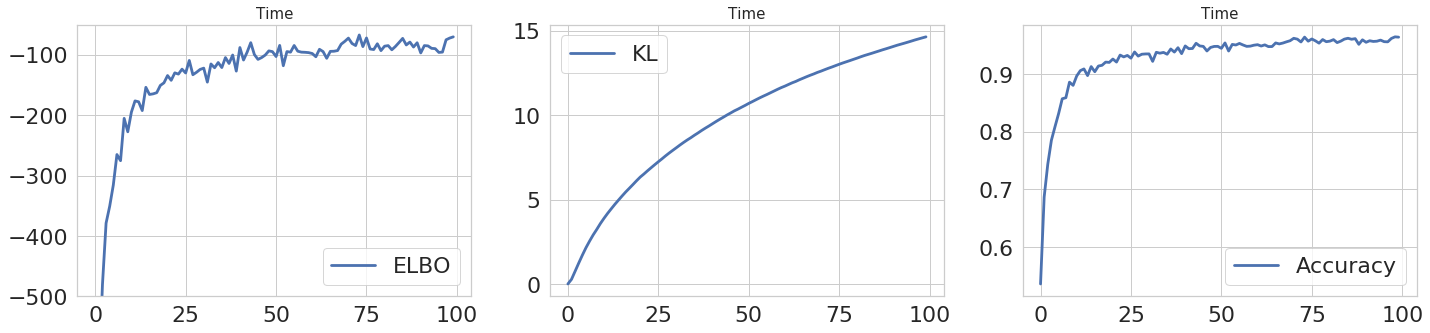

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(3*8,5))

axes[0].plot(reparam_elbos, label='ELBO')
axes[0].set_title('Time', fontsize=15)
axes[0].set_ylim((-500, -50))
axes[0].legend()

axes[1].plot(reparam_kls, label='KL')
axes[1].set_title('Time', fontsize=15)
axes[1].legend()

axes[2].plot(reparam_accuracies, label='Accuracy')
axes[2].set_title('Time', fontsize=15)
axes[2].legend()

## Training the model via reinforce

## Task: define the surrogate reinforce loss for the log prob term.

Note: we do not need to use reinforce the KL term, since we can compute the KL analytically for the two Gaussians, and can use standard backprop. 

For the reinforce implementation, instead of changing the gradients, we will change the loss such that TensorFlow's automatic differentiation does the right thing. This is called a surrogate loss. 

The gradient we want to obtain is the following (since we want to minimize the loss, we add a minus):
\begin{equation}
- \mathbb{E}_{q_{\theta}(w)} \left[ \nabla_{\theta} \log q_{\theta}(w) \mathbb{E}_{p^*(x, y)} \log p(y| x, w) \right]
\end{equation}

so we need to construct a loss which has this gradient, by ensuring that the gradients will flow through the $\log q_{\theta}(w)$ term, but not the rest. 

In [0]:
# Since TensorFlow does automatic differentation, we have to use 
# tf.stop_gradient to ensure the gradient !_only_flows_! to
# the log_{q_\theta}(w) term.
per_sample_reinforce_loss = -tf.stop_gradient(param_log_probs)*posterior.log_prob(tf.stop_gradient(posterior_samples))  # Shape [num_samples, batch size].
# Reduce now over the number of samples.
reinforce_loss = tf.reduce_mean(per_sample_reinforce_loss) + kl #tale vrstica ti naredi tisti zunanji expectation. tanotranji expectation je pa narejen ze nekje v eni od zgornjih celic (tam kjer sumamo/averageamo po batchu).



In [0]:
optimizer = tf.train.GradientDescentOptimizer(0.0001)
reinforce_min_op = optimizer.minimize(reinforce_loss)

In [0]:
NUM_ITERATIONS = 1000

In [62]:
reinforce_accuracies = []
reinforce_kls = []
reinforce_elbos = []

sess = tf.Session()

# Initialize all variables
sess.run(tf.initialize_all_variables())

for i in xrange(NUM_ITERATIONS):
  sess.run(reinforce_min_op)

  if i % 10 == 0:
    reinforce_acc, reinforce_kl, reinforce_elbo = sess.run([accuracy, kl, elbo])
    reinforce_accuracies += [reinforce_acc]
    reinforce_kls += [reinforce_kl]
    reinforce_elbos += [reinforce_elbo]

    print('Iteration {}. Elbo {}. KL {}'.format(
        i, reinforce_elbo, reinforce_kl))

reinforce_learned_mean, reinforce_learned_log_scale = sess.run(learned_vars)

Iteration 0. Elbo -1264.86010742. KL 0.0169694069773
Iteration 10. Elbo -689.8828125. KL 0.406080245972
Iteration 20. Elbo -497.553436279. KL 0.891268253326
Iteration 30. Elbo -419.460662842. KL 1.3592966795
Iteration 40. Elbo -399.536804199. KL 1.88225066662
Iteration 50. Elbo -313.028900146. KL 2.30571317673
Iteration 60. Elbo -288.394927979. KL 2.67438960075
Iteration 70. Elbo -232.134628296. KL 3.00853157043
Iteration 80. Elbo -217.006561279. KL 3.31562328339
Iteration 90. Elbo -203.153686523. KL 3.64438796043
Iteration 100. Elbo -190.448013306. KL 3.92471075058
Iteration 110. Elbo -210.835876465. KL 4.15419006348
Iteration 120. Elbo -203.819213867. KL 4.41300058365
Iteration 130. Elbo -192.832855225. KL 4.6386961937
Iteration 140. Elbo -175.646362305. KL 4.87356853485
Iteration 150. Elbo -191.283538818. KL 5.10979557037
Iteration 160. Elbo -180.681716919. KL 5.35692310333
Iteration 170. Elbo -145.590332031. KL 5.62900781631
Iteration 180. Elbo -165.358474731. KL 5.88225269318
Iter

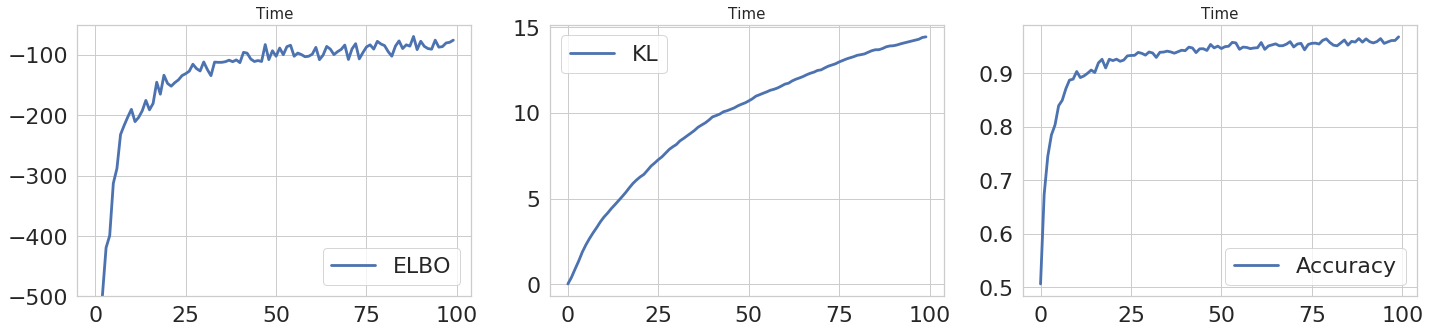

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(3*8,5))

axes[0].plot(reinforce_elbos, label='ELBO')
axes[0].set_title('Time', fontsize=15)
axes[0].set_ylim((-500, -50))
axes[0].legend()

axes[1].plot(reinforce_kls, label='KL')
axes[1].set_title('Time', fontsize=15)
axes[1].legend()

axes[2].plot(reinforce_accuracies, label='Accuracy')
axes[2].set_title('Time', fontsize=15)
axes[2].legend()

## Task: Analysis

* How sensitive are the different estimators to the number of posterior samples used? Try 1, 10, 100.
* How sensitive are the different estimators to the learning rate used? Try 1e-4, 1e-3 and 1e-2 for both estimators.
* How sensitive are the different estimators to batch size? Try batch size 10 for both estimators.

# Visualize learned parameters

* Let's visualize the learned parameters, as well as check the different uncertanties around different parameters
* Can we now see which parameters are most important in the classification problem?

In [0]:
learned_mean = reparam_learned_mean
learned_scale = np.exp(reparam_learned_log_scale)

In [0]:
PARAM_INDEX = 10

In [0]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,1,'Parameter name= radius error')

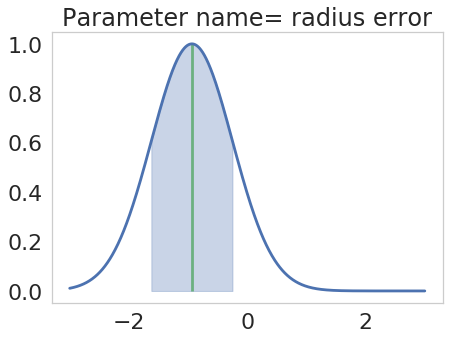

In [67]:
mean = learned_mean[PARAM_INDEX]
scale = learned_scale[PARAM_INDEX]
x_values = np.linspace(-3, 3, num=1000)
y_values = [gaussian(x, mean, scale) for x in x_values]

plt.figure(figsize=(7,5))
plt.plot(x_values, y_values)
plt.vlines(
      learned_mean[PARAM_INDEX], 
      ymin=0, 
      ymax=gaussian(mean, mean, scale),
      colors='g',
      alpha=0.8)

plt.grid('off')
x_std_values = np.linspace(mean - scale, mean + scale, num=1000)
y_std_values = [gaussian(x, mean, scale) for x in x_std_values]
plt.fill_between(x_std_values, y_std_values, 0, alpha=0.3, color='b')

plt.title('Parameter name= {}'.format(feature_names[PARAM_INDEX]))

## Visualize gradient variance - which estimator has lower variance?

* Let's assess the gradient variance per of each estimator, by looking at how much gradients vary for each estimators. 

In [0]:
def per_batch_grads(ys, xs):
  """Computes the gradients of ys[i] wrt xs."""
  grads = []

  for y in tf.unstack(ys, axis=0):
    grads.append(tf.squeeze(tf.gradients(y, xs)[0]))
  return tf.stack(grads, axis=0)

In [0]:
def compute_grad_var(grads, param_index):
  return np.mean(grads[:, param_index]), np.std(grads[:, param_index])**2

In [70]:
per_batch_reinforce_grads = per_batch_grads(per_sample_reinforce_loss, learned_vars[0])
per_batch_reinforce_grads.shape

TensorShape([Dimension(100), Dimension(31)])

In [71]:
per_batch_reparam_grads = per_batch_grads(per_sample_reparametrization_loss, learned_vars[0])
per_batch_reparam_grads.shape

TensorShape([Dimension(100), Dimension(31)])

In [0]:
reinforce_grads = []

sess = tf.Session()

# Initialize all variables
sess.run(tf.initialize_all_variables())

for i in xrange(NUM_ITERATIONS):
  sess.run(reinforce_min_op)

  if i % 10 == 0:
    reinforce_grads.append(sess.run(per_batch_reinforce_grads))

In [0]:
reparam_grads = []

sess = tf.Session()

# Initialize all variables
sess.run(tf.initialize_all_variables())

for i in xrange(NUM_ITERATIONS):
  sess.run(reparam_min_op)

  if i % 10 == 0:
    reparam_grads.append(sess.run(per_batch_reparam_grads))

In [0]:
PARAM_INDEX = 19

In [0]:
reinforce_grad_vars = []
for timestep_grad in reinforce_grads:
  _, reinforce_grad_var = compute_grad_var(timestep_grad, PARAM_INDEX)
  reinforce_grad_vars.append(reinforce_grad_var)

In [0]:
reparam_grad_vars = []
for timestep_grad in reparam_grads:
  _, reparam_grad_var = compute_grad_var(timestep_grad, PARAM_INDEX)
  reparam_grad_vars.append(reparam_grad_var)

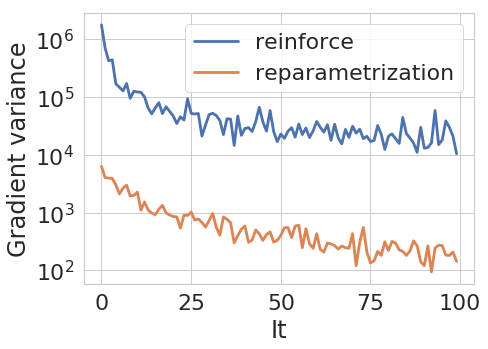

In [80]:
plt.figure(figsize=(7,5))
plt.plot(reinforce_grad_vars, label='reinforce')
plt.plot(reparam_grad_vars, label='reparametrization')
plt.yscale('log')
plt.xlabel('It')
plt.ylabel('Gradient variance')
plt.legend()

### Task: Analysis

* What do you notice about gradient variance as training progresses?
* What do you notice about the variance of the different estimators?
* How do batch size and number of posterior samples affect the variance of the different estimators?
* How does gradient variance affect convergence?
* Which gradient estimator would you use in practice for this problem?

## More

You can find similar experiments with more analysis and more gradient estimators in [this paper](https://arxiv.org/pdf/1906.10652.pdf). See Section 8.3.